# PerturbationX
PerturbationX is a package for analyzing causal networks in combination with gene expression data. It is based on the [TopoNPA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4227138/) algorithm. It was developed as part of a Master's thesis at the University of Ljubljana, Faculty of Computer and Information Science and in collaboration with the National Institute of Biology. This notebook demonstrates the use of PerturbationX for analyzing a small causal network.

## Installation
The package can be installed from PyPI or directly from GitHub. It requires a Python version of 3.10 or newer. It is based on NetworkX and pandas and requires Cytoscape for visualization. The latter can be downloaded from [here](https://cytoscape.org/download.html).

```bash
python -m pip install perturbationx # PyPI
python -m pip install git+https://github.com/mikethenut/perturbationx # GitHub
```

## Network import
For demonstration purposes, a small example network with accompanying datasets is included in the package. The network core is based on the human Osmotic Stress network from the [Causal Biological Networks database](https://www.causalbionet.com/), available under Network ID [osmotic_stress_2.0_hs](https://www.causalbionet.com/Home/NetworkVisualization/networkGraph?ID=osmotic_stress_2.0_hs). All non-causal edges were removed and the largest connected component was then selected. The network boundary and datasets were generated synthetically and do not correspond to any real biological system.

In [1]:
import perturbationx as px
from perturbationx import CausalNetwork

core_network_file = px.resources.get_osmotic_stress_core_path() # path to the network core
boundary_network_file = px.resources.get_osmotic_stress_boundary_path() # path to the network boundary
osmotic_stress_network = CausalNetwork.from_tsv(core_network_file, edge_type="core")
osmotic_stress_network.add_edges_from_tsv(boundary_network_file, edge_type="boundary")

In this example, we imported core and boundary edges separately. The files contain three columns, with a header row of 'subject', 'object', and 'relation'. Adding a 'type' column would allow us to concatenate the files and import them in one step. When the input file specifies valid edge types in this way, the argument passed to the import function is ignored.

A CausalNetwork can also be instantiated from CSV files (from_csv), other delimited files (from_dsv), Cytoscape json files (from_cyjs_json), NetworkX graphs (from_networkx), and pandas DataFrames (from_pandas). Refer to the documentation for more information.

## Network manipulation
We can now inspect the network. We will first look at the number of nodes and edges.

In [2]:
node_count = osmotic_stress_network.number_of_nodes()
core_node_count = osmotic_stress_network.number_of_nodes(typ="core")
edge_count = osmotic_stress_network.number_of_edges()
core_edge_count = osmotic_stress_network.number_of_edges(typ="core")

print(f"Number of nodes: {node_count}, {core_node_count} of which are core nodes.")
print(f"Number of edges: {edge_count}, {core_edge_count} of which are core edges.")

Number of nodes: 131, 0 of which are core nodes.
Number of edges: 436, 40 of which are core edges.


Wait, why does the network report zero core nodes? This is because node types are inferred dynamically during computation. While the network contains 131 nodes, none of them are currently assigned to the core or boundary. In order to see what the algorithm will do, we can use the following command.

In [3]:
osmotic_stress_network.infer_graph_attributes(inplace=True)

# Recompute node counts
core_node_count = osmotic_stress_network.number_of_nodes(typ="core")
boundary_node_count = osmotic_stress_network.number_of_nodes(typ="boundary")

print(f"The network contains {core_node_count} core nodes and {boundary_node_count} boundary nodes.")

2023-11-05 17:44:36,552 INFO -- core edges: 40
2023-11-05 17:44:36,553 INFO -- boundary edges: 396
2023-11-05 17:44:36,554 INFO -- core nodes: 31
2023-11-05 17:44:36,554 INFO -- outer boundary nodes: 100
2023-11-05 17:44:36,555 INFO -- core nodes with boundary edges (inner boundary): 10
The network contains 31 core nodes and 100 boundary nodes.


As we can see, the nodes are now correctly assigned. We obtained the same statistics from internal logs. Logging is enabled by default and can be disabled by setting `verbose=False`.

Next, let's try adding a new edge to the network.

In [4]:
src, trg = 'a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)'
osmotic_stress_network.add_edge(src, trg, '1.0')

for edge in osmotic_stress_network.edges():
    v1, v2, data = edge
    if v1 == src and v2 == trg:
        print("New edge: " + str(edge))

New edge: ('a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)', {'relation': '1.0', 'type': 'infer'})


The edge was successfully added, however its type was set to 'infer'. Let's specify the edge's type to prevent any errors during computation.

In [5]:
osmotic_stress_network.modify_edge(src, trg, typ='core')

for edge in osmotic_stress_network.edges():
    v1, v2, data = edge
    if v1 == src and v2 == trg:
        print("Updated edge: " + str(edge))

Updated edge: ('a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)', {'relation': '1.0', 'type': 'core'})


We specified the edge relation as `1.0`. This is the causal relationship between vertices and is used to assign edge weights during computation. By default, numeric parsing is enabled to allow setting weights directly. The default settings also map `increases`, `directlyIncreases`, `->` and `=>` to a weight of 1.0, and `decreases`, `directlyDecreases`, `-|` and `=|` to a weight of -1.0. Different syntax can be used, however the mapping must be specified by correctly configuring the `RelationTranslator` class and passing it to the causal network. Unexpected relations will be mapped to a weight of zero, indicating no causal relationship. Refer to the documentation for more information.

## Computing the NPA score

Let's remove the extra edge and import our test datasets.

In [6]:
osmotic_stress_network.remove_edge(src, trg)

import pandas as pd

datasets = dict()
idx = 1
for dataset_path in px.resources.get_osmotic_stress_dataset_paths():
    data_name = "test_%d" % idx
    datasets[data_name] = pd.read_table(dataset_path)
    idx += 1

The implemention expects datasets to be passed as a dictionary of pandas DataFrames. Each DataFrame should contain at least the columns `nodeID` and `logFC`, however `t` or `stderr` are also required for computing statistics. We will now pass our dataset map to the network and begin computation.

In [7]:
test_results = osmotic_stress_network.toponpa(datasets)

2023-11-05 17:44:38,104 INFO -- PREPROCESSING NETWORK
2023-11-05 17:44:38,118 INFO -- core edges: 40
2023-11-05 17:44:38,119 INFO -- boundary edges: 396
2023-11-05 17:44:38,120 INFO -- core nodes: 31
2023-11-05 17:44:38,121 INFO -- outer boundary nodes: 100
2023-11-05 17:44:38,122 INFO -- core nodes with boundary edges (inner boundary): 10
2023-11-05 17:44:38,687 INFO -- COMPUTING NPA FOR DATASET 'test_1'
2023-11-05 17:44:38,690 INFO -- boundary nodes matched with dataset: 100
2023-11-05 17:44:38,691 INFO -- boundary edges remaining: 385
2023-11-05 17:44:38,692 INFO -- core nodes with boundary edges remaining: 7
2023-11-05 17:44:40,081 INFO -- COMPUTING NPA FOR DATASET 'test_2'
2023-11-05 17:44:40,084 INFO -- boundary nodes matched with dataset: 100
2023-11-05 17:44:40,085 INFO -- boundary edges remaining: 385
2023-11-05 17:44:40,085 INFO -- core nodes with boundary edges remaining: 7
2023-11-05 17:44:41,452 INFO -- COMPUTING NPA FOR DATASET 'test_3'
2023-11-05 17:44:41,455 INFO -- bou

Results contain four types of information: global, node, distribution, and metadata. Let's first take a look at global and node information.

In [8]:
display(test_results.global_info())

print(test_results.node_attributes())
display(test_results.node_info("test_3"))

,NPA,variance,ci_lower,ci_upper,o_value,k2_value
test_1,0.005144,0.000568,-0.041569,0.051856,0.114,0.012
test_2,0.117399,0.016193,-0.132009,0.366806,0.000,0.002
test_3,1.750560,8.072700,-3.818187,7.319307,0.000,0.002


['contribution', 'coefficient', 'variance', 'ci_lower', 'ci_upper', 'p_value']


attr,contribution,coefficient,variance,ci_lower,ci_upper,p_value
"p(HGNC:CFTR,pmod(P,S,768))",0.028921,0.711537,0.270254,-0.307369,1.730444,0.085545
cat(p(HGNC:PTGES2)),0.025182,-0.663954,0.230599,-1.605142,0.277235,0.083388
a(SCHEM:Dinoprostone),0.048062,-0.748938,0.268949,-1.765380,0.267504,0.074349
kin(p(HGNC:MAPK14)),0.027421,-0.692837,0.354713,-1.860148,0.474474,0.122353
p(HGNC:SLC6A12),0.031004,-0.758725,0.892567,-2.610416,1.092967,0.210962
p(HGNC:AQP3),0.012135,-0.651810,0.238653,-1.609295,0.305674,0.091061
p(HGNC:AQP5),0.038163,-0.667370,0.255508,-1.658088,0.323348,0.093371
p(HGNC:AKR1B1),0.013488,-0.687185,0.441027,-1.988795,0.614424,0.150390
kin(p(HGNC:ATM)),0.049270,-0.656697,0.455038,-1.978821,0.665426,0.165149
"bp(GOBP:""hyperosmotic response"")",0.083611,-0.698490,0.293734,-1.760736,0.363757,0.098735


The datasets all have nonsensical variance due to their synthetic nature. Regardless, we can see that the NPA scores vary significantly. For the dataset with the lowest score, the permutation tests produced p-values above `0.05`, indicating that the result is not significant.

Node information is accessed by specifying either the name of a dataset or a node attribute. The TopoNPA algorithm assigns six attributes per dataset: contribution, coefficient, variance, lower and upper confidence interval limits, and p-values. The last four are all derived from standard error and are thus unrealistic in this example. Coefficients are counterparts to the `logFC` values we provided for boundary nodes. Contributions are estimates of how important a node is for the total NPA score. Since we have a lot of nodes, we might want to look at only the ones with the highest contribution.

In [9]:
leading_nodes_2 = test_results.get_leading_nodes("test_2")
leading_nodes_3 = test_results.get_leading_nodes("test_3")

print("Leading nodes for both datasets: " + str(leading_nodes_2.intersection(leading_nodes_3)))
print("Leading nodes for only dataset 2: " + str(leading_nodes_2.difference(leading_nodes_3)))
print("Leading nodes for only dataset 3: " + str(leading_nodes_3.difference(leading_nodes_2)))

Leading nodes for both datasets: {'kin(p(HGNC:ATM))', 'p(HGNC:CFTR,pmod(P,S,768))', 'a(SCHEM:Dinoprostone)', 'kin(p(SFAM:"MAPK Erk1/2 Family"))', 'p(HGNC:AQP5)', 'p(HGNC:AQP1)', 'kin(p(SFAM:"PRKA Family"))', 'kin(p(HGNC:MAPK14))', 'bp(GOBP:"hyperosmotic response")', 'p(HGNC:NRG1)', 'p(HGNC:SLC6A12)', 'tscript(p(HGNC:HIF1A))', 'tscript(p(HGNC:NFAT5))', 'a(CHEBI:"hydrogen peroxide")', 'tport(p(HGNC:CFTR))'}
Leading nodes for only dataset 2: {'cat(p(HGNC:ERBB3))'}
Leading nodes for only dataset 3: {'p(HGNC:EGF)', 'cat(p(HGNC:PTGES2))', 'cat(p(HGNC:PTGS2))'}


Comparing leading nodes between the two datasets with significant results, we can see that there is a high degree of conformity. While this is not guaranteed (especially when using synthetic data), it is likely that the same nodes will show up across different datasets.

Next, let's take a look at permutation test distributions.

In [10]:
print(test_results.distributions())

['o', 'k2']


By default, two permutation tests are computed. The `O` permutation test shuffles boundary nodes and tests the significance of their ordering. The `K2` permutation test shuffles core edges according to the degree sequence and tests the importance of the core network structure. A `K1` test is also available, which shuffles edges completely at random. The tests can be further adjusted via optional arguments. Refer to the documentation for more information.

<Figure size 640x480 with 0 Axes>

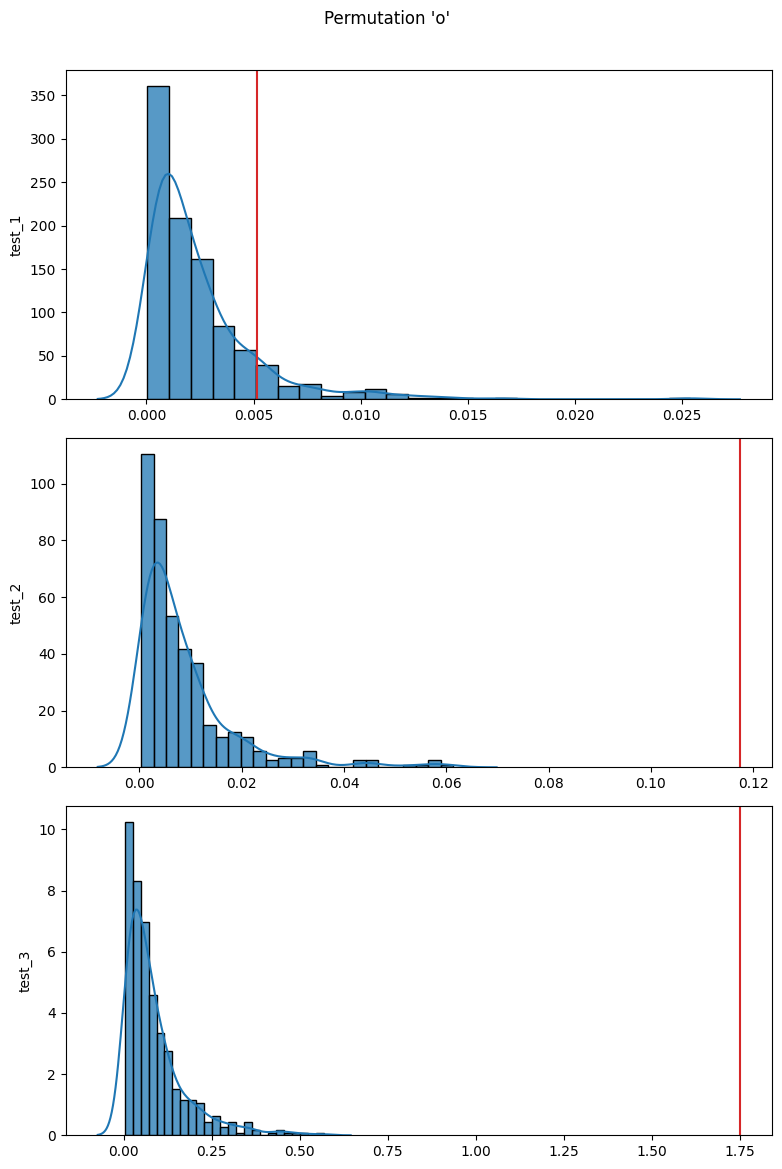

array([<Axes: ylabel='test_1'>, <Axes: ylabel='test_2'>,
       <Axes: ylabel='test_3'>], dtype=object)

In [11]:
test_results.plot_distribution('o')

<Figure size 640x480 with 0 Axes>

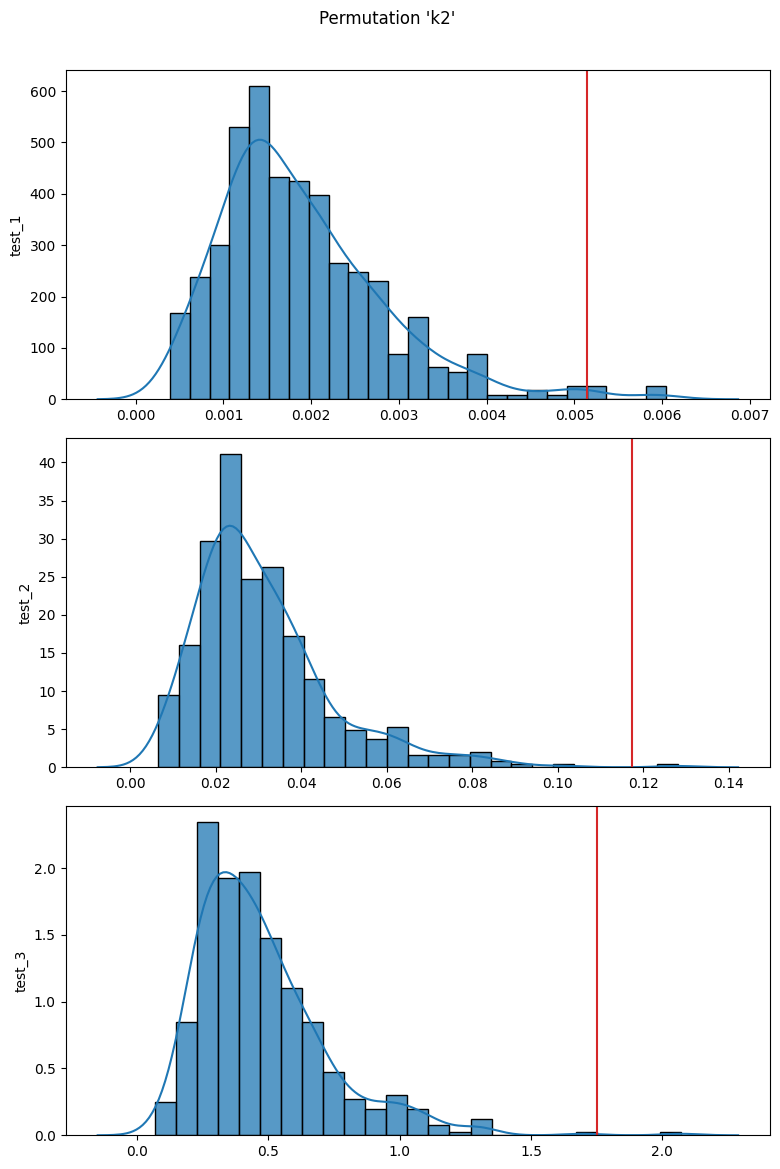

array([<Axes: ylabel='test_1'>, <Axes: ylabel='test_2'>,
       <Axes: ylabel='test_3'>], dtype=object)

In [12]:
test_results.plot_distribution('k2')

Finally, we can inspect the metadata. Information about the programming environment, package version, network and dataset information is all added automatically. Additional metadata can be assigned to a CausalNetwork through the metadata attribute, and it will appear here prepended with `network_`.

Results can be exported to a JSON file using the `to_json()` method.

In [13]:
display(test_results.metadata())

{'missing_value_pruning_mode': 'nullify',
 'opposing_value_pruning_mode': None,
 'opposing_value_minimum_amplitude': 1.0,
 'boundary_edge_minimum': 6,
 'exact_boundary_outdegree': True,
 'alpha': 0.95,
 'full_core_permutation': True,
 'permutation_iterations': 500,
 'permutation_rate': 1.0,
 'seed': None,
 'datetime_utc': '2023-11-05T16:44:42.812720',
 'python_implementation': 'CPython',
 'python_version': '3.10.0',
 'system_name': 'Windows',
 'system_release': '10',
 'system_version': '10.0.19045',
 'network_core_edges': 40,
 'network_boundary_edges': 396,
 'network_core_nodes': 31,
 'network_outer_boundary_nodes': 100,
 'network_inner_boundary_nodes': 10,
 'network_title': 'osmotic_stress_core',
 'network_collection': 'resources',
 'dataset_test_1': {'matched_outer_boundary_nodes': 100,
  'matched_boundary_edges': 385,
  'matched_inner_boundary_nodes': 7},
 'network_dataset_test_1': {'matched_outer_boundary_nodes': 100,
  'matched_boundary_edges': 385,
  'matched_inner_boundary_nodes

## Network visualization

The last feature that the result object offers is Cytoscape integration through the py4cytoscape package. Let's import the package and verify that Cytoscape is running.

In [14]:
import py4cytoscape as p4c
p4c.cytoscape_version_info()

2023-11-05 17:44:47,561 DEBUG -- Calling cytoscape_version_info()
2023-11-05 17:44:47,563 DEBUG -- ǀCalling cyrest_get('version', base_url='http://127.0.0.1:1234/v1')
2023-11-05 17:44:47,564 DEBUG -- Attempting to direct connect to Cytoscape on http://127.0.0.1:1234/v1
2023-11-05 17:44:47,581 DEBUG -- Detected py4cytoscape running on Cytoscape workstation
2023-11-05 17:44:47,583 DEBUG -- ǀHTTP GET(http://127.0.0.1:1234/v1/version)
2023-11-05 17:44:47,599 DEBUG -- ǀOK[200], content: {"apiVersion":"v1","cytoscapeVersion":"3.10.1"}
2023-11-05 17:44:47,601 DEBUG -- ǀReturning 'cyrest_get': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1'}
2023-11-05 17:44:47,603 DEBUG -- Returning 'cytoscape_version_info': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1', 'automationAPIVersion': '1.8.0', 'py4cytoscapeVersion': '1.8.0'}
2023-11-05 17:44:47,607 DEBUG -- --------------------


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.1',
 'automationAPIVersion': '1.8.0',
 'py4cytoscapeVersion': '1.8.0'}

If no errors were returned, we can display our results.

In [15]:
cynet = test_results.display_network()

Applying default style...
Applying preferred layout


The method returns an NPAResultDisplay instance, which we can use to further adjust the display. For example, we can color the nodes using any node attribute and any dataset. Let's show node contributions for the `test_3` dataset.

In [16]:
cynet_suid = cynet.color_nodes("test_3", "contribution")

While coloring nodes is helpful for identifying key parts of the network, it is insufficient when viewing large networks. For this reason, two methods were implemented for visualizing leading nodes The first is `highlight_leading_nodes`. 

In [17]:
cynet_suid = cynet.highlight_leading_nodes("test_3")

All leading nodes have now been highlighted with an emboldened node border. To include related edges and edges we can specify optional arguments. Let's try it on the second method, `extract_leading_nodes`.

In [18]:
cynet_suid = cynet.extract_leading_nodes("test_3", include_shortest_paths="directed", path_length_tolerance=1)

By default, this method performs extraction in place by hiding all unselected nodes and edges. We have included shortest directed paths between each pair of leading nodes, with a path length tolerance of $1$. The length tolerance selects also paths that are up to $1$ edge longer than the shortest path. It is also possible to select undirected shortest paths, however this usually results in a smaller subgraph, as the edges do not need to be directed in the same way.

The other way to include related nodes is by selecting neighbors. Let's use out-of-place extraction for that.

In [19]:
subnet_suid = cynet.extract_leading_nodes("test_3", include_neighbors=1, neighborhood_type="union", inplace=False)

As we can see, the entire core network was selected, as every node is at most one edge away from a leading node. If we instead chose a neighborhood type of intersection, the nodes would have to be first neighbors of all leading nodes to be included. It is also possible to combine display of neighborhoods and paths. In this case, the selected nodes and edges are combined.

The extracted subnetwork inherits the network style of the original. We can always reset the display to clear coloring, highlights and invisibility.

In [20]:
cynet.reset_display(reset_color=True, reset_highlight=True, reset_visibility=True)

128

## Advanced usage

The package offers some additional options when it comes to network analysis. Once imported, parts of the core network can be randomly wired or rewired. Let's try adding two random edges between a couple of nodes.

In [21]:
modifications = osmotic_stress_network.wire_edges(
    ['tport(p(HGNC:CFTR))', 'p(HGNC:EGFR,pmod(P,Y))', 'a(SCHEM:Calcium)', 'p(HGNC:HSPA1A)'], 
    number_of_edges=2, iterations=5, edge_relations=[1, -1], datasets=None
)
for modification in modifications:
    display(modification)

2023-11-05 17:45:07,408 INFO -- WIRING EDGES


[('p(HGNC:EGFR,pmod(P,Y))', 'a(SCHEM:Calcium)', 1, 'core'),
 ('p(HGNC:HSPA1A)', 'a(SCHEM:Calcium)', 1, 'core')]

[('a(SCHEM:Calcium)', 'p(HGNC:EGFR,pmod(P,Y))', 1, 'core'),
 ('tport(p(HGNC:CFTR))', 'p(HGNC:EGFR,pmod(P,Y))', -1, 'core')]

[('p(HGNC:HSPA1A)', 'p(HGNC:EGFR,pmod(P,Y))', 1, 'core'),
 ('p(HGNC:HSPA1A)', 'tport(p(HGNC:CFTR))', 1, 'core')]

[('tport(p(HGNC:CFTR))', 'a(SCHEM:Calcium)', 1, 'core'),
 ('tport(p(HGNC:CFTR))', 'a(SCHEM:Calcium)', -1, 'core')]

[('p(HGNC:HSPA1A)', 'tport(p(HGNC:CFTR))', -1, 'core'),
 ('a(SCHEM:Calcium)', 'p(HGNC:EGFR,pmod(P,Y))', 1, 'core')]

If we don't pass in any datasets, we will only recieve lists of modifications. These can be applied to the network using the `modify_network` method. Modifications can also be constructed and passed in by hand. If a relation of an edge is set to None, the edge will instead be deleted from the network.

If we pass in our test datasets, we will also receive an evaluation of the permutations using the TopoNPA algorithm.

In [22]:
results = osmotic_stress_network.wire_edges(
    ['tport(p(HGNC:CFTR))', 'p(HGNC:EGFR,pmod(P,Y))', 'a(SCHEM:Calcium)', 'p(HGNC:HSPA1A)'], 
    number_of_edges=2, iterations=5, edge_relations=[1, -1], datasets=datasets
)

for modification, scores in results:
    display(modification)
    display(scores)

2023-11-05 17:45:10,729 INFO -- WIRING EDGES
2023-11-05 17:45:10,738 INFO -- PREPROCESSING NETWORK
2023-11-05 17:45:10,754 INFO -- COMPUTING NPA FOR DATASET 'test_1'
2023-11-05 17:45:10,757 INFO -- boundary nodes matched with dataset: 100
2023-11-05 17:45:10,758 INFO -- boundary edges remaining: 385
2023-11-05 17:45:10,759 INFO -- core nodes with boundary edges remaining: 7
2023-11-05 17:45:10,777 INFO -- COMPUTING NPA FOR DATASET 'test_2'
2023-11-05 17:45:10,782 INFO -- boundary nodes matched with dataset: 100
2023-11-05 17:45:10,783 INFO -- boundary edges remaining: 385
2023-11-05 17:45:10,783 INFO -- core nodes with boundary edges remaining: 7
2023-11-05 17:45:10,801 INFO -- COMPUTING NPA FOR DATASET 'test_3'
2023-11-05 17:45:10,805 INFO -- boundary nodes matched with dataset: 100
2023-11-05 17:45:10,806 INFO -- boundary edges remaining: 385
2023-11-05 17:45:10,806 INFO -- core nodes with boundary edges remaining: 7


[('tport(p(HGNC:CFTR))', 'p(HGNC:EGFR,pmod(P,Y))', 1, 'core'),
 ('p(HGNC:EGFR,pmod(P,Y))', 'p(HGNC:HSPA1A)', 1, 'core')]

{'test_1': 0.005262609151602442,
 'test_2': 0.11588824017787205,
 'test_3': 1.7978651652176179}

[('tport(p(HGNC:CFTR))', 'a(SCHEM:Calcium)', 1, 'core'),
 ('p(HGNC:EGFR,pmod(P,Y))', 'tport(p(HGNC:CFTR))', 1, 'core')]

{'test_1': 0.002821991068645036,
 'test_2': 0.06333980089431542,
 'test_3': 0.9806944500603834}

[('tport(p(HGNC:CFTR))', 'p(HGNC:EGFR,pmod(P,Y))', -1, 'core'),
 ('p(HGNC:HSPA1A)', 'tport(p(HGNC:CFTR))', -1, 'core')]

{'test_1': 0.00257330586388104,
 'test_2': 0.05932423372006398,
 'test_3': 0.7920323450800411}

[('p(HGNC:EGFR,pmod(P,Y))', 'p(HGNC:HSPA1A)', 1, 'core'),
 ('tport(p(HGNC:CFTR))', 'p(HGNC:HSPA1A)', -1, 'core')]

{'test_1': 0.0028847859324918177,
 'test_2': 0.06447048198098623,
 'test_3': 0.9109864912582095}

[('a(SCHEM:Calcium)', 'p(HGNC:HSPA1A)', -1, 'core'),
 ('a(SCHEM:Calcium)', 'tport(p(HGNC:CFTR))', 1, 'core')]

{'test_1': 0.0027311364170748654,
 'test_2': 0.05931376219821324,
 'test_3': 0.9118963822303352}

A number of optional arguments are available to adjust evaluation, both in edge wiring and standard computation. We briefly describe them here and explain the logic behind them. An in-depth evaluation was performed as part of the Master's thesis "Integration of gene expression data with causal networks", which can be found in the root of the project's repository.

### Missing value pruning mode
When values aren't passed for boundary nodes, their associated edges must be removed. We have two options when doing this: we can either first remove the edge weights for missing edges and then balance, or we can first balance the weights and then remove the edges. The first option can be selected by passing "remove". It indicates that the edge was somehow incorrect and should not have been included. The second option is the default and can be selected by passing "nullify". It indicates that the edge should be included, but cannot be processed in the current computation.

### Boundary edge minimum
Although weights are expected for boundary edges, they are not used directly. Instead, the absolute weights of all boundary edges that share a source core node are first balanced, so that they sum to $1$. This ensures that boundary edges do not overtake the core edges in terms of importance for the NPA score. However, that can still occur if a core node only has a few boundary edges, resulting in large weights. This is why a boundary edge minimum is applied, and the boundary edges of any core node that are fewer in number are removed. Specifically, they are removed at the same time as boundary weights are balanced. If the number of edges falls below the minimum afterwards, during edge nullification, the remaining edges are not removed. The parameter defaults to $6$ and can be set to $0$ to remove this behaviour altogether.

### Exact boundary outdegree
When we use nullification to remove edges, the absolute weights of boundary edges for a core node will no longer sum to $1$. In this case, we can choose to use the exact boundary outdegrees of core nodes when computing the NPA score, which is the default behavior. Alternatively, we may choose to use binary outdegrees, which are $1$ for any node with at least one boundary outdegree, and $0$ otherwise. The second option was selected as the default behavior in the R NPA package.

### Opposing value pruning mode
Sometimes, we may encounted data that causally opposes our biological understanding. For example, we may select three regulators **A**, **B**, and **C**, which all promote the expression of **X**, yet we observe a decrease of **X** in our measurements. Should the decrease still be processed by those edges? If we would like to avoid this, we can use an opposing value pruning mode of either "remove" or "nullify", similar to the removal of edges for missing values. By default, this behaviour is disabled with a value of `None`.

### Opposing value minimum amplitude
Although many measurements may oppose our causal edges, most of them are likely to be insignificant. In this case, the insignificance of the measurement is likely more important than its causality. Following this logic, only measurements with a large enough absolute value should be considered as causally opposing and removed. This parameter defaults to a value of $1$, and is disregarded when opposing value pruning is not used.